# Imports and constants

In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from classifiers.utils.feature_extractors import ColorHistogramTransformer, HuMomentsTransformer, HaralickFeaturesTransformer

from classifiers.utils.load_balanced_data import load_balanced_data_pipeline

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.ensemble import AdaBoostClassifier

# Load and preprocess data

In [6]:
metadata_path = "HAM10000_metadata.csv"
image_dir = "HAM10000_images_part_1"

augmented_images, augmented_labels = load_balanced_data_pipeline(metadata_path, image_dir)

Loading balanced data...
Metadata loaded.
Generating image ID list...
Image ID list generated.
Loading images for augmentation...
Augmenting images...
Images augmented.
Data loading complete.


# Train/test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)

y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

# Feature extraction and AdaBoost pipeline

In [8]:
feature_union = FeatureUnion([
    ("color_histogram", ColorHistogramTransformer()),
    ("hu_moments", HuMomentsTransformer()),
    ("haralick_features", HaralickFeaturesTransformer())
])

scaler = StandardScaler()

ada_boost_pipeline = Pipeline([
    ("features", feature_union),
    ("scaler", scaler),
    ("classifier", AdaBoostClassifier(algorithm='SAMME'))
])

param_grid = {
    "classifier__n_estimators": [200],
    "classifier__learning_rate": [0.5]
}

grid_search = GridSearchCV(ada_boost_pipeline, param_grid, cv=5, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train_1d)

# Predict the labels for the test using AdaBoost
y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


# Classification report

In [9]:
# Evaluate the AdaBoost classifier
print("AdaBoost Classification Report:")
print(classification_report(y_test_1d, y_pred))
print("Accuracy:", accuracy_score(y_test_1d, y_pred))
print("Best parameters:", grid_search.best_params_)

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.19      0.22        32
           1       0.51      0.57      0.54        40
           2       0.32      0.29      0.30        35
           3       0.40      0.38      0.39        42
           4       0.41      0.60      0.49        43
           5       0.66      0.69      0.67        42
           6       0.82      0.61      0.70        46

    accuracy                           0.49       280
   macro avg       0.48      0.48      0.47       280
weighted avg       0.50      0.49      0.49       280

Accuracy: 0.4928571428571429
Best parameters: {'classifier__learning_rate': 0.5, 'classifier__n_estimators': 200}


# Confusion matrix

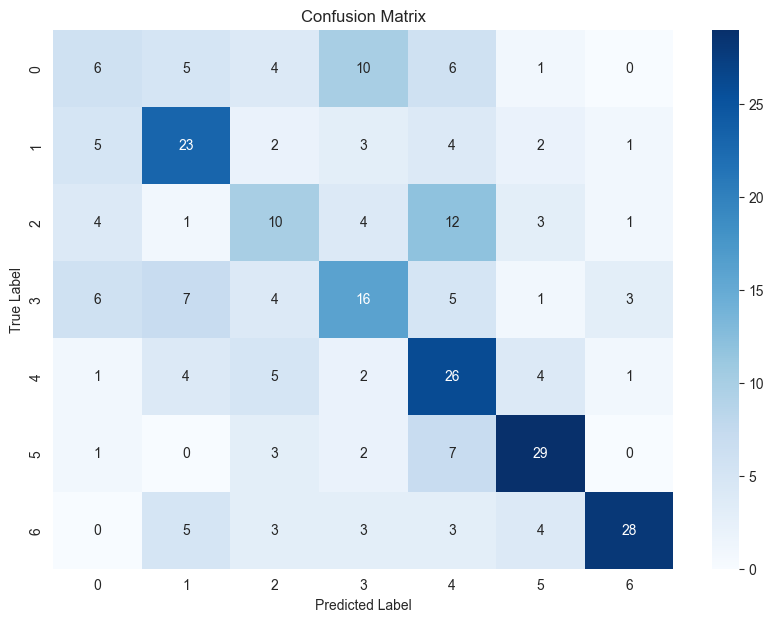

In [10]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_1d, y_pred)



# ROC curve and AUC

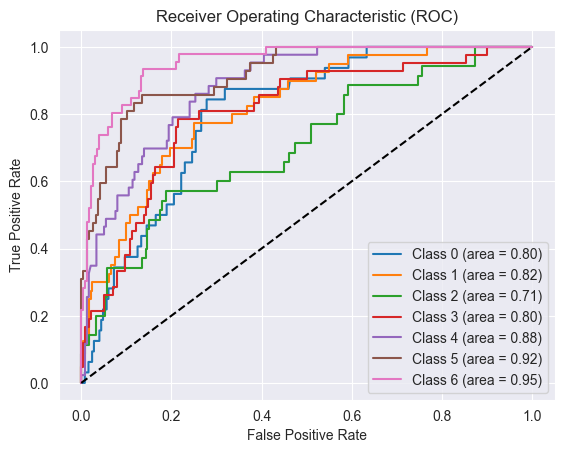

In [11]:
y_score = grid_search.predict_proba(X_test)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_train.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_score[:, i])
    
# Plot the ROC curve for each class
plt.figure()
for i in range(y_train.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curve

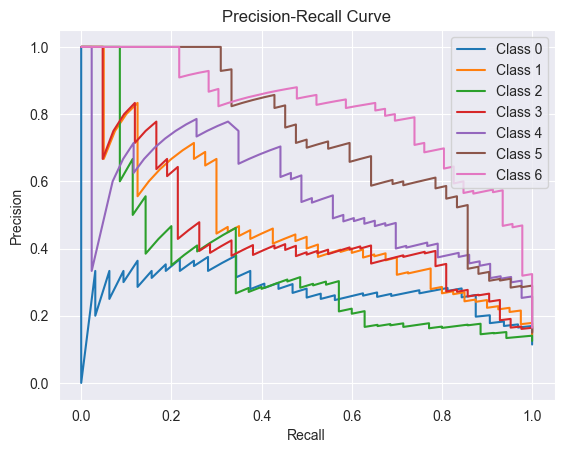

In [12]:
# Compute precision-recall curve for each class
precision = {}
recall = {}
for i in range(y_train.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])

# Plot Precision-Recall curve for each class
plt.figure()
for i in range(y_train.shape[1]):
    plt.plot(recall[i], precision[i], label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Save the model

In [13]:
import joblib

joblib_file = "ada_boost_classifier.pkl"
joblib.dump(grid_search.best_estimator_, joblib_file)

['ada_boost_classifier.pkl']